In [1]:
from ibapi.contract import Contract
from datetime import timedelta, time
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytz import timezone

from TaranTrading.taran_wrapper import TaranWrapper

import warnings
warnings.filterwarnings("ignore")

In [12]:
def plot_histogram(series, bins = 100, ylabel = '', xlabel = '', title = ''):
    assert isinstance(series, pd.Series)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.hist(series, bins)
    plt.show()

def plot_scatterplot(series_1, series_2, ylabel = '', xlabel = '', title = ''):
    assert isinstance(series_1, pd.Series)
    assert isinstance(series_2, pd.Series)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.scatter(series_1, series_2)
    plt.show()    
    
def calculate_pnls(ticker, spread_threshold = 0.0, nominal_value_for_quote = 5000):
    wrapper = TaranWrapper()

    contract.symbol = ticker

    dataPreSaleTrades = wrapper.getHistoricalPreSaleData(contract, timeFrom, timeTo, timeZ, 'TRADES')
    dataPreSaleBidAsk = wrapper.getHistoricalPreSaleData(contract, timeFrom, timeTo, timeZ, 'BID_ASK')

    dataPreSaleBidAsk['timeBidAsk'] = dataPreSaleBidAsk['time']
    dataPreSale = pd.merge_asof(dataPreSaleTrades, dataPreSaleBidAsk, on='time', allow_exact_matches=False, direction='backward')

    dataDaily = wrapper.getHistoricalOpenData(contract)

    # find previous date for close
    dataDaily1 = dataDaily[["date"]].copy(deep=True)
    dataDaily2 = dataDaily1.copy(deep=True)
    dataDaily1['key'] = 0
    dataDaily2['key'] = 0

    dataJoined = dataDaily1.merge(dataDaily2, on='key', suffixes=("", "_prev"))
    dataJoined = dataJoined[dataJoined["date"] > dataJoined["date_prev"]]
    dataJoined = dataJoined.drop('key', axis=1)
    dataPreviousDate = dataJoined.groupby("date").max()

    data = dataPreSale.merge(dataDaily, on='date')
    data = data.merge(dataPreviousDate, on='date')
    data = data.merge(dataDaily, left_on='date_prev', right_on='date', suffixes=("", "_prev"))
    data = data.drop('date_prev', axis=1)

    #print(data)

    wrapper.quit()
    
    data_filtered = data[['time','price','size','date','priceBid','priceAsk','timeBidAsk','open','close_prev']]
    
    data_filtered['abs_dev_from_open'] = data_filtered.apply(lambda x: abs(x['price']/x['open']-1), axis = 1)
    data_filtered['abs_dev_from_bid'] = data_filtered.apply(lambda x: abs(x['price']/x['priceBid']-1) if x['priceBid']>0 else 1, axis = 1)
    data_filtered['abs_dev_from_ask'] = data_filtered.apply(lambda x: abs(x['price']/x['priceAsk']-1) if x['priceAsk']>0 else 1, axis = 1)
    data_filtered['abs_dev_trade'] = data_filtered.apply(lambda x: min(x['abs_dev_from_bid'],x['abs_dev_from_ask']), axis = 1)
    data_filtered['side'] = data_filtered.apply(lambda x: 'buy' if x['abs_dev_from_bid'] <= x['abs_dev_from_ask'] else 'sell', axis = 1)
    data_filtered['pnl_total'] = data_filtered.apply(lambda x: (x['price']-x['open'])*x['size']*lotSize if x['side'] == 'sell' else (x['open']-x['price'])*x['size']*lotSize, axis = 1)
    data_filtered['pnl'] = data_filtered.apply(lambda x: min(x['pnl_total']*(nominal_value_for_quote/((x['priceBid']+x['priceAsk'])/2))/(x['size']*lotSize),x['pnl_total']) if x['pnl_total'] >0 else max(x['pnl_total']*(nominal_value_for_quote/((x['priceBid']+x['priceAsk'])/2))/(x['size']*lotSize),x['pnl_total']), axis = 1)
    data_filtered['spread'] = data_filtered.apply(lambda x: (x['priceAsk']-x['priceBid'])/((x['priceBid']+x['priceAsk'])/2), axis = 1)
    # display(data_filtered)
    
    print()
    print(contract.symbol)
    
    print('Pre-open trades count: ', len(data_filtered))
    print('Pre-open trades aggregated PnL: ', data_filtered['pnl'].sum())
    plot_scatterplot(data_filtered['spread'], data_filtered['pnl'], ylabel = 'pnl', xlabel = 'spread')
    print('Pre-open trades with spread threshold count: ', len(data_filtered[data_filtered['spread']>spread_threshold]))
    print('Pre-open trades with spread threshold PnL: ', data_filtered[data_filtered['spread']>spread_threshold]['pnl'].sum())
    plot_scatterplot(data_filtered[data_filtered['spread']>spread_threshold]['spread'], data_filtered[data_filtered['spread']>spread_threshold]['pnl'], ylabel = 'pnl', xlabel = 'spread')

In [13]:
contract = Contract()
contract.exchange = 'SMART'
contract.secType = 'STK'
contract.currency = 'USD'

lotSize = 100

timeFrom = time(hour=4)
timeTo = time(hour=9,minute=30)
timeZ = timezone('US/Eastern')

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

TGP
Pre-open trades count:  91
Pre-open trades aggregated PnL:  3.03379478305294


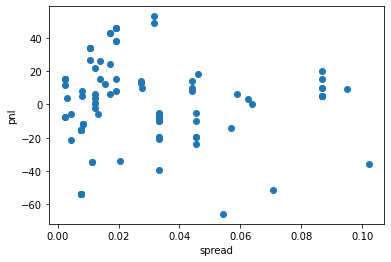

Pre-open trades with spread threshold count:  16
Pre-open trades with spread threshold PnL:  -73.70320908485792


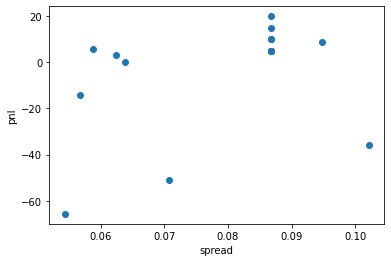

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

TK
Pre-open trades count:  203
Pre-open trades aggregated PnL:  5032.028510396014


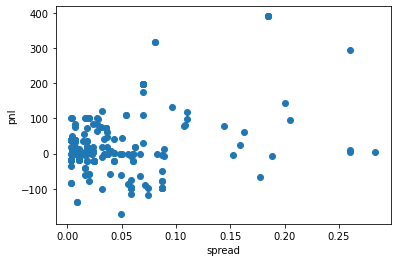

Pre-open trades with spread threshold count:  75
Pre-open trades with spread threshold PnL:  3745.33504747806


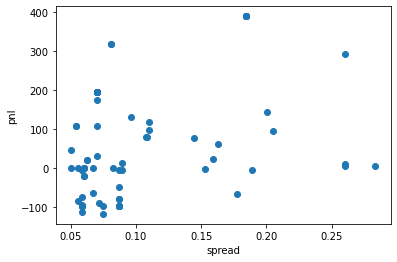

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

OSG
Pre-open trades count:  31
Pre-open trades aggregated PnL:  479.6567353433422


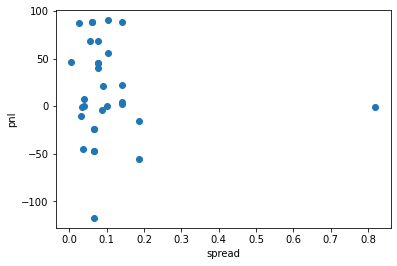

Pre-open trades with spread threshold count:  24
Pre-open trades with spread threshold PnL:  394.76824715500396


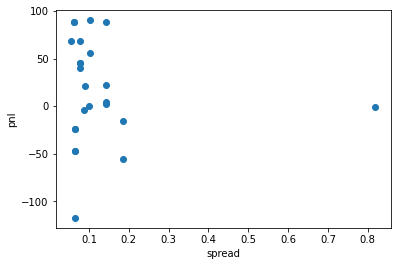

In [14]:
tickers = ['TGP', 'TK', 'OSG']

for ticker in tickers:
    calculate_pnls(ticker, spread_threshold = 0.05)

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

DSSI
Pre-open trades count:  91
Pre-open trades aggregated PnL:  1554.7249640223872


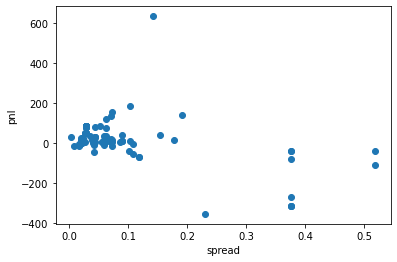

Pre-open trades with spread threshold count:  44
Pre-open trades with spread threshold PnL:  -296.59574837260567


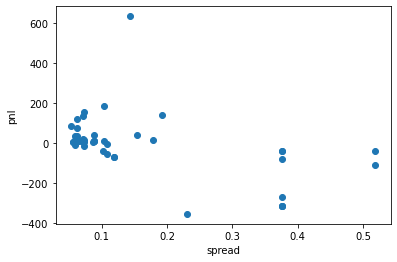

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

GASS
Pre-open trades count:  69
Pre-open trades aggregated PnL:  -550.6609498683545


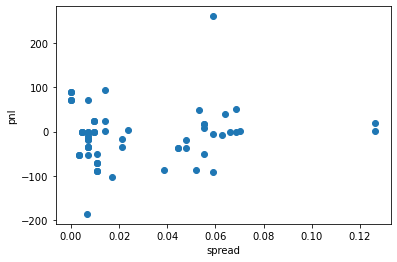

Pre-open trades with spread threshold count:  17
Pre-open trades with spread threshold PnL:  220.80722413076973


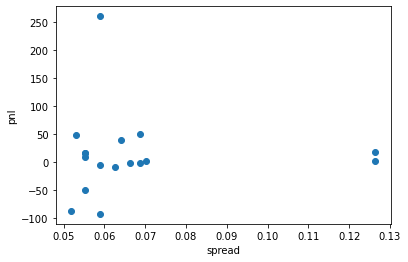

In [15]:
tickers = ['DSSI', 'GASS']

for ticker in tickers:
    calculate_pnls(ticker, spread_threshold = 0.05)

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

TNK
Pre-open trades count:  150
Pre-open trades aggregated PnL:  346.78863434329264


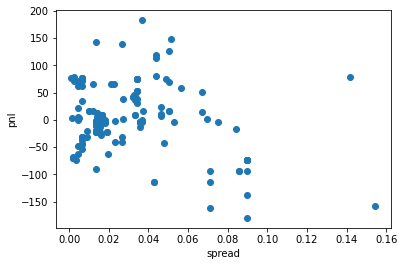

Pre-open trades with spread threshold count:  27
Pre-open trades with spread threshold PnL:  -934.6192989950861


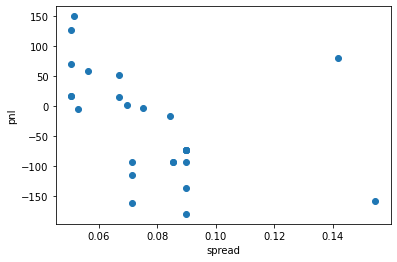

In [16]:
tickers = ['TNK']

for ticker in tickers:
    calculate_pnls(ticker, spread_threshold = 0.05)

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

INSW
Pre-open trades count:  19
Pre-open trades aggregated PnL:  178.28953153552402


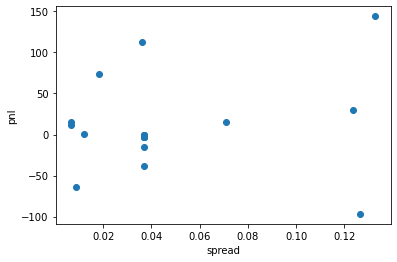

Pre-open trades with spread threshold count:  4
Pre-open trades with spread threshold PnL:  92.37760180687927


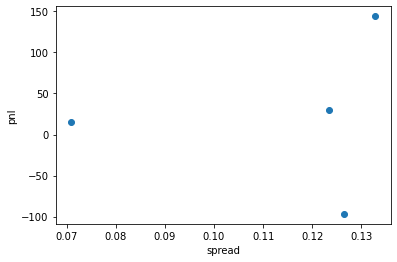

In [17]:
#tickers = ['GLNG','ASC', 'INSW']
tickers = ['INSW']

for ticker in tickers:
    calculate_pnls(ticker, spread_threshold = 0.05)

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

SFL
Pre-open trades count:  262
Pre-open trades aggregated PnL:  1095.4367648221614


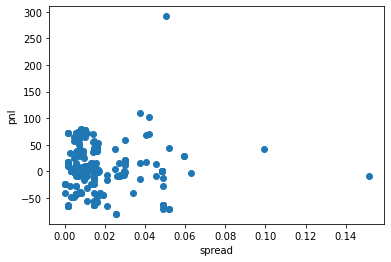

Pre-open trades with spread threshold count:  9
Pre-open trades with spread threshold PnL:  282.6121431427834


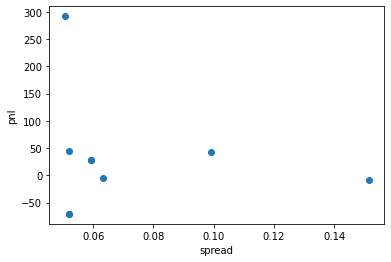

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

STNG
Pre-open trades count:  909
Pre-open trades aggregated PnL:  15879.052837339881


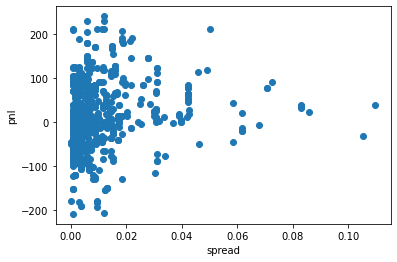

Pre-open trades with spread threshold count:  17
Pre-open trades with spread threshold PnL:  570.5752341499592


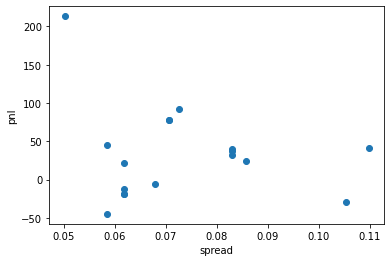

In [18]:
tickers = ['SFL', 'STNG']

for ticker in tickers:
    calculate_pnls(ticker, spread_threshold = 0.05)

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

GNK
Pre-open trades count:  91
Pre-open trades aggregated PnL:  1163.4685903914008


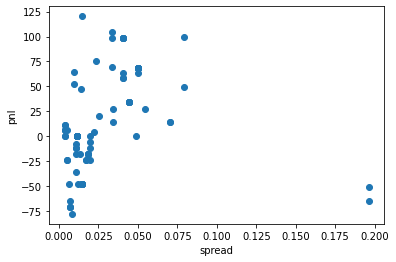

Pre-open trades with spread threshold count:  15
Pre-open trades with spread threshold PnL:  631.0243936180387


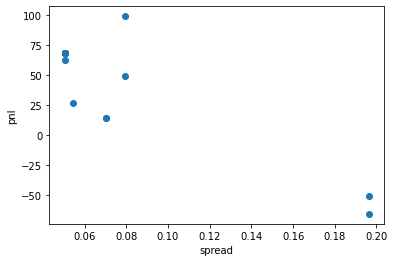

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

LPG
Pre-open trades count:  170
Pre-open trades aggregated PnL:  6562.4230104185635


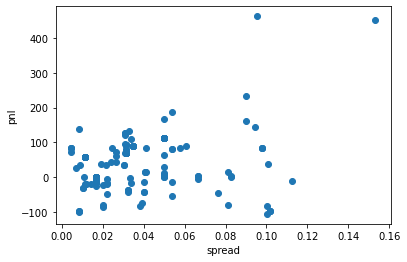

Pre-open trades with spread threshold count:  53
Pre-open trades with spread threshold PnL:  3243.227059980747


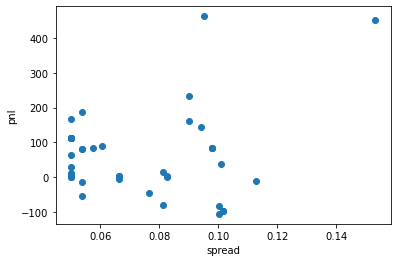

In [19]:
tickers = ['GNK','LPG']

for ticker in tickers:
    calculate_pnls(ticker, spread_threshold = 0.05)

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

ET
Pre-open trades count:  9135
Pre-open trades aggregated PnL:  74031.42350001345


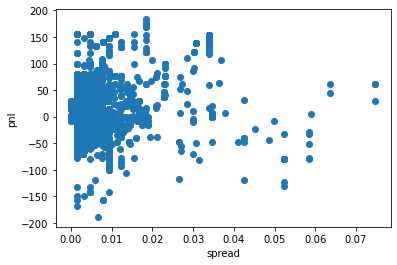

Pre-open trades with spread threshold count:  25
Pre-open trades with spread threshold PnL:  -1172.9811912567561


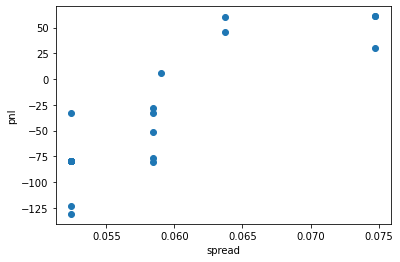

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

CPLP
Pre-open trades count:  29
Pre-open trades aggregated PnL:  161.51383932803245


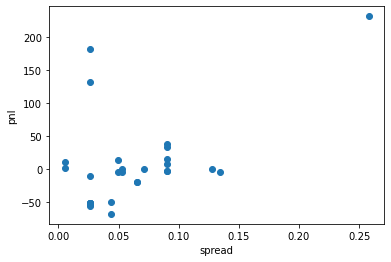

Pre-open trades with spread threshold count:  14
Pre-open trades with spread threshold PnL:  270.33809240531474


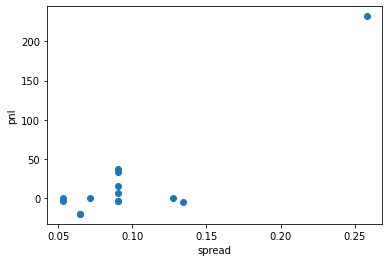

In [20]:
tickers = ['ET', 'CPLP']

for ticker in tickers:
    calculate_pnls(ticker, spread_threshold = 0.05)

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

PAA
Pre-open trades count:  568
Pre-open trades aggregated PnL:  5733.766099266084


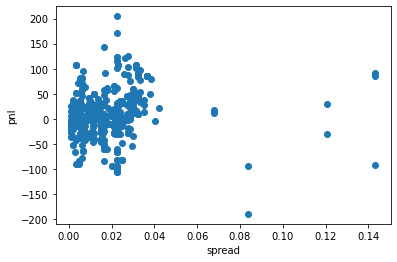

Pre-open trades with spread threshold count:  9
Pre-open trades with spread threshold PnL:  -168.50600385353792


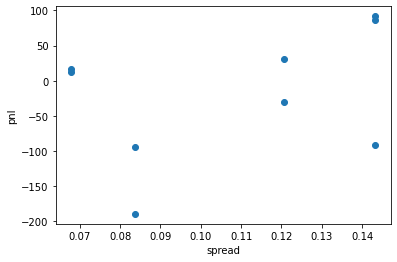

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

EPD
Pre-open trades count:  3848
Pre-open trades aggregated PnL:  6430.691312154022


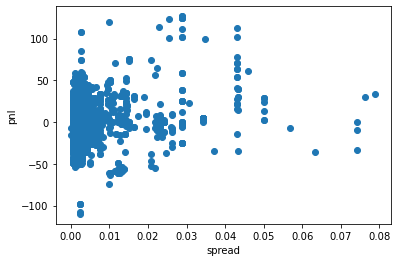

Pre-open trades with spread threshold count:  14
Pre-open trades with spread threshold PnL:  106.56250022111283


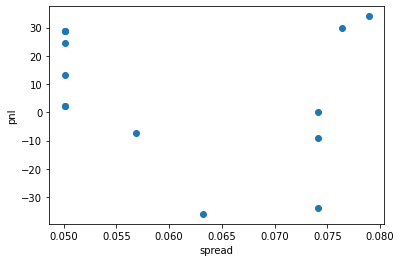

In [21]:
tickers = ['PAA', 'EPD']

for ticker in tickers:
    calculate_pnls(ticker, spread_threshold = 0.05)

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

NMCI
Pre-open trades count:  264
Pre-open trades aggregated PnL:  7054.792133121765


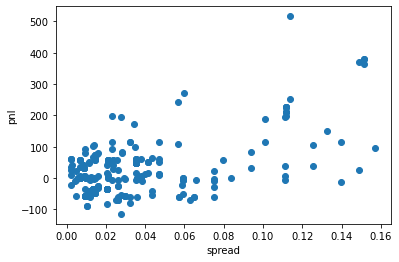

Pre-open trades with spread threshold count:  52
Pre-open trades with spread threshold PnL:  5376.771996631123


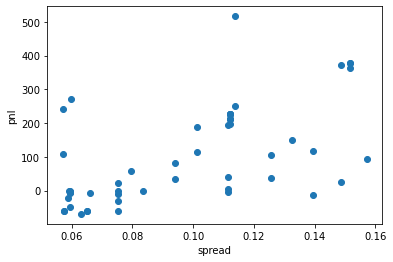

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

FLNG
Pre-open trades count:  76
Pre-open trades aggregated PnL:  -1363.7108058879521


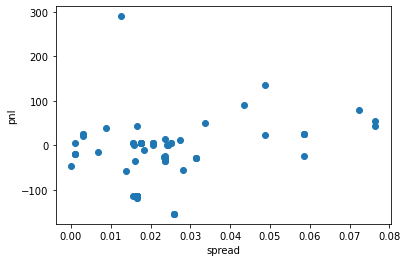

Pre-open trades with spread threshold count:  7
Pre-open trades with spread threshold PnL:  227.76571991302518


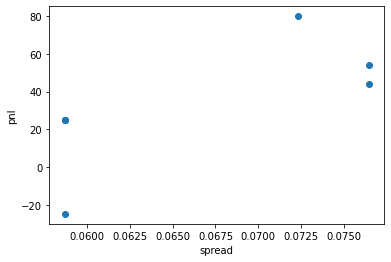

In [22]:
tickers = ['NMCI', 'FLNG']

for ticker in tickers:
    calculate_pnls(ticker, spread_threshold = 0.05)

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

SHLX
Pre-open trades count:  409
Pre-open trades aggregated PnL:  2731.675397731703


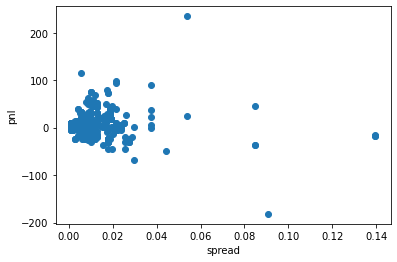

Pre-open trades with spread threshold count:  9
Pre-open trades with spread threshold PnL:  -2.6684388596452777


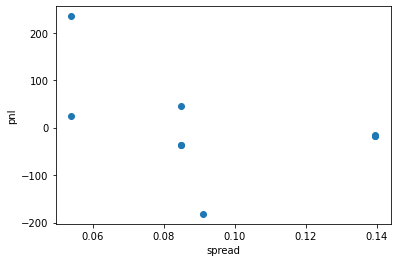

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

ETRN
Pre-open trades count:  298
Pre-open trades aggregated PnL:  -1211.8590798175496


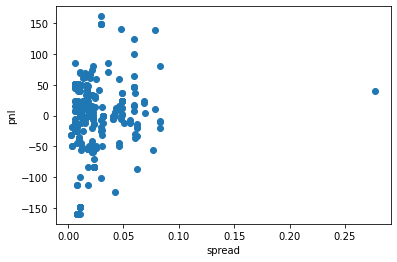

Pre-open trades with spread threshold count:  32
Pre-open trades with spread threshold PnL:  500.38704289708426


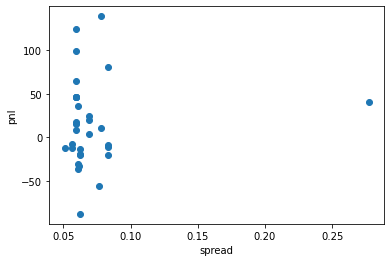

Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm.nj
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:cashfarm
Error. Id: -1, Code: 2104 Msg: Market data farm connection is OK:usfarm
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:hkhmds
Error. Id: -1, Code: 2106 Msg: HMDS data farm connection is OK:ushmds
Error. Id: -1, Code: 2158 Msg: Sec-def data farm connection is OK:secdefhk

AROC
Pre-open trades count:  85
Pre-open trades aggregated PnL:  2874.463383493285


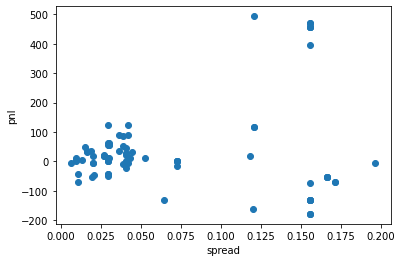

Pre-open trades with spread threshold count:  35
Pre-open trades with spread threshold PnL:  1978.2771408028455


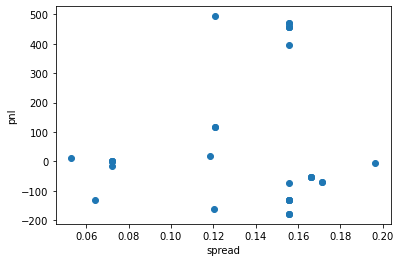

In [23]:
tickers = ['SHLX', 'ETRN', 'AROC']

for ticker in tickers:
    calculate_pnls(ticker, spread_threshold = 0.05)